# Genome-wide runs and their analysis

**Setting up source files and directories:**

```bash
scriptDir=/nfs/team144/ds26/scripts/burden_testing
phenoDir=/lustre/scratch115/projects/t144_helic_15x/analysis/HA/phenotypes/correct_names.andmissing
workingDir=/lustre/scratch115/realdata/mdt0/projects/t144_helic_15x/analysis/HA/burdentesting/Miss_0.01
cd $workingDir
```
**General trait-wide and genome-wide run:**

Genome-wide runs for all traits listed in the traits folder:
```bash
ls "${phenoDir}" | perl -lane '$_ =~ /\.(.+)\./; print $1'| while read trait; do
    echo $trait
    
    # Non weighted exon run with 50bp extension severe variants:
    bsub -M1000 -R'select[mem>1000] rusage[mem=1000]' \
        -J "Exon_lof_noweight_${trait}_[1-30]" \
        -e "logs/exon_only/Exon_lof_noweight_${trait}_%I.e" \
        -o "logs/exon_only/Exon_lof_noweight_${trait}_%I.o" \
        -q normal \
        "${scriptDir}/MONSTERgenome-wide.sh -g exon -m 0.05 -d 30 -w $(pwd) -p ${trait} -x 50 -o"
done
```

* `-M1000 -R'select[mem>1000] rusage[mem=1000]'` - requesting 1GB RAM must be enough.
* `-q normal` - selecting normal queue.
* `-J "Exon_lof_noweight_${trait}_[1-30]"` - the list of ~20k genes are split into 30 chunks containing ~650 genes in each. This list not too big to fit into the time limit of the normal queue. When the number of the job array is modified, the -d parameter of the wrapper has to be also adjusted. 

## Setting up the wrapper:

### Score related options:
* **-s**: scores applied to the selected variants (not case sensitive). The accepted scores: CADD (which is CADD-phred), Eigen, EigenPhred, EigenPC, EigenPCPhred, Linsight, Mixed. (Mixed is a combination of CADD and EigenPhred scores)
* **-k**: score cutoff below which the variant is excluded from the test. It is important to note that the variants are still being scored, not only filtered based on the score!
* **-t**: the value with which the scores will be shifted. It is important if the scores could be negative, as MONSTER cant handle scores <= 0!. When raw Eigen scores are applied this value is 1 by default (it can be overriden by specifying with -t).


### Parameters to define genomic regions:

* **-g**: selected GENCODE feature. It could be **exon**, **gene**, transcript etc.
* **-e**: selected regulatory features associated by GTEx, we use: promoter,enhancer,TF_bind
* **-l**: selected regulatory features associated by overlap, we use: promoter,enhancer,TF_bind
* **-x**: number of baseparis the exons(!) are extended. We ended up using 50. It ensures the important splice region variants of the introns are included. 

### Variant filters:

* **-m**: upper MAF threshold, above which the variant will not be included. We use 0.05.
* **-o**: if this switch is set, only severe variants will be included. (More severe than synonymous variants based on Ensembl prediction, read from the vcf file info field)
* **-f**: if this switch is turned on, only variants that are predicted to be high or low (HC/LC) confident loss of function by loftee is considered. (This information is read from the vcf info field)


### Parameters defining the gene list and chunking:
* **-L**: gene list file. By default this is the full set of protein coding genes.
* **-d 30**: the number of chunks the submitted gene list is split into. This number should be the same as the number of jobs in the array!
* **-c**: the currently processed chunk. By default it is 1, but if jobarray is submitted it is read from the **LSB_JOBINDEX** variable.

### Other options:
* **-h**: prints out help and exit.
* **-w**: the working directory where the output files will be generated. By default this is the working direcory.
* **-p TG**: the tested trait. The corresponding phenotype has to be found in the phenotype folder. No default value.
* **-b**: if switched on, temporary files will not be deleted (except the big, mod files) Use it for diagnostic purposes.
* **-i**: Set the significance threshold of the burden p-value below which the hit will be tested and saved. By default the threshold is 1e-5.
* **-a**: if switched on, hits with low p-values are saved but not tested. It could save time, if a known set of hits are re-run. 

### Sample loftee run:
```bash
# Non weighted, severe variants based on loftee prediction:
${scriptDir}/MONSTERgenome-wide.sh -g gene -m 0.05 -d 30 -w $(pwd) -p ${trait} -f
```

### Sample exon only runs:
```bash
# Non weighted exon run with 50bp extension severe variants:
${scriptDir}/MONSTERgenome-wide.sh -g exon -m 0.05 -d 30 -w $(pwd) -p ${trait} -x 50 -o

# CADD-Phred weighted run with 50bp extension:
${scriptDir}/MONSTERgenome-wide.sh -g exon -m 0.05 -d 30 -w $(pwd) -p ${trait} -x 50 -s CADD

# CADD-Phred weighted exons:
${scriptDir}/MONSTERgenome-wide.sh -g exon -m 0.05 -d 30 -w $(pwd) -p ${trait} -s CADD

# CADD-Phred weighted exons, with a median filter applied on the scores:
${scriptDir}/MONSTERgenome-wide.sh -g exon -m 0.05 -d 30 -w $(pwd) -p ${trait} -s CADD -k 5.851

# Linsight weighted exons:
${scriptDir}/MONSTERgenome-wide.sh -g exon -m 0.05 -d 30 -w $(pwd) -p ${trait} -x 50 -s Linsight
```

### Exon (50bp exended) + regulatory regions:

```bash
# Eigen phred weighted:
${scriptDir}/MONSTERgenome-wide.sh -m 0.05 -d 30 -w $(pwd) -p ${trait} \
            -s EigenPhred -g exon -e promoter,enhancer,TF_bind -l promoter,enhancer,TF_bind -x 50

# Mixed weights: exons weighted with CADD-Phred, regulatory regions weighted using EigenPhred
${scriptDir}/MONSTERgenome-wide.sh -m 0.05 -d 30 -w $(pwd) -p ${trait} \
            -s Mixed -g exon -e promoter,enhancer,TF_bind -l promoter,enhancer,TF_bind -x 50

# EigenPCPhred weighted:
${scriptDir}/MONSTERgenome-wide.sh -g exon -m 0.05 -d 30 -w $(pwd) -p ${trait} \
            -s EigenPCPhred -e promoter,enhancer,TF_bind -l promoter,enhancer,TF_bind -x 50

# Linsight weighted:
${scriptDir}/MONSTERgenome-wide.sh -m 0.05 -d 30 -w $(pwd) -p ${trait} \
            -s linsight -g exon -e promoter,enhancer,TF_bind -l promoter,enhancer,TF_bind -x 50

# Raw Eigen scores, shifted by 1:
${scriptDir}/MONSTERgenome-wide.sh -g exon -m 0.05 -d 30 -w $(pwd) -p ${trait} \
            -s Eigen -t 1 -e promoter,enhancer,TF_bind -l promoter,enhancer,TF_bind -x 50
```

###  Only regulatory regions:

```bash
# Variants weighted by EigenPhred scores:
${scriptDir}/MONSTERgenome-wide.sh -m 0.05 -d 30 -w $(pwd) -p ${trait} \
            -s EigenPhred -e promoter,enhancer,TF_bind -l promoter,enhancer,TF_bind

# Weighted by Linsight:
${scriptDir}/MONSTERgenome-wide.sh -m 0.05 -d 30 -w $(pwd) -p ${trait} \
            -s Linsight -e promoter,enhancer,TF_bind -l promoter,enhancer,TF_bind
```

## The output 

The output files are structured according to the input parameters:

**Example on a Exon+reg. run weighted by EigenPCPhred:**
```
├── exon.GTEX.promoter,enhancer,TF_bind.Overlap.promoter,enhancer,TF_bind.MAF.0.05.EigenPCPhred.Xtend.50
│   ├── Pheno.adiponectin
│   │   ├── gene_set.1
│   │   │   └── results
│   │   ├── gene_set.2
│   │   │   ├── results
│   │   ├── failed
│   │   │   └── failed_genes.tar
│   │   ├── hits
│   │       └── ACTR1A.tar.gz
```

* All phenotypes tested with the same setting will be stored under the same setting specific main directory (**Pheno.adiponectin**). 
* Within the phenotype folder there will be sub-folders for each chunk that were run parallel (**gene_set.1**).
* Within each chunk there will be a **results** file with the p-values of the genes of that chunk. 
* If the gene failed is stored in the **failed** subdirectory for diagnostic reasons. 
* If a significant gene is found, it is saved in the **hits** directory in the trait folder.

**The results file:**

Tab separated file, where the first column is the gene name, the second is the burden p-value, the third is the number of snps within the burden.

```
KRT20    5.8853e-01  7
FBP2     4.8218e-01  12
HERPUD2  9.0075e-02  22
ST20     2.2030e-01  12
CARM1    5.7721e-01  41
CDX2     3.9245e-01  15
BRD1     3.2944e-02  45
TAF1C    3.6858e-01  63
GPR158   3.8769e-01  47
DPRX     8.9130e-01  4
```

## Checking the output of the genome-wide runs

Once the runs are completed we have to check if all the genes have processed. Recently, `/lustre/scratch115` has troubles, and file access often takes too long, which extends the average runtime for a gene, leading to failing jobs because of exceeding the time limit of the normal queue. Such failed jobs don't have to be completely re-run, just those genes that are missing from the results file. For this purpose, I have created the following script that helps to do this automatically:

```bash
# Setting directories:
scriptDir=/nfs/team144/ds26/burden_testing/Summary_true_signals/2017.02.24/temp_scripts
phenoDir=/lustre/scratch115/projects/t144_helic_15x/analysis/HA/phenotypes/correct_names.andmissing
workingDir=/lustre/scratch115/realdata/mdt0/projects/t144_helic_15x/analysis/HA/burdentesting/Miss_0.01_MONSTER_fixed
geneFile=${scriptDir}/gene_list.lst
phenotypes=$(ls $phenoDir | sed -e 's/MANOLIS\.//;s/\.txt//')
cd $workingDir

# Define folders:
declare -A Folders
Folders=(
    [exon_CADD]="exon.MAF.0.05.CADD"
    [exon_CADD_med]="exon.MAF.0.05.CADD.cutoff.5.851"
    [exon_CADD_x50]="exon.MAF.0.05.CADD.Xtend.50"
    [exon_lof]="exon.MAF.0.05.lof.noweights.Xtend.50"
    [EigenRaw]="exon.GTEX.promoter,enhancer,TF_bind.Overlap.promoter,enhancer,TF_bind.MAF.0.05.Eigen.Xtend.50.shift.1"  
    [exon_reg]="exon.GTEX.promoter,enhancer,TF_bind.Overlap.promoter,enhancer,TF_bind.MAF.0.05.EigenPhred.Xtend.50"
 [EigenPCphred]="exon.GTEX.promoter,enhancer,TF_bind.Overlap.promoter,enhancer,TF_bind.MAF.0.05.EigenPCPhred.Xtend.50"
    [exonregmixed]="exon.GTEX.promoter,enhancer,TF_bind.Overlap.promoter,enhancer,TF_bind.MAF.0.05.Mixed.Xtend.50"
    [regonly]="GTEX.promoter,enhancer,TF_bind.Overlap.promoter,enhancer,TF_bind.MAF.0.05.EigenPhred"
    [exon_linsight]="exon.MAF.0.05.Linsight.Xtend.50"
 [exonreg_linsight]="exon.GTEX.promoter,enhancer,TF_bind.Overlap.promoter,enhancer,TF_bind.MAF.0.05.Linsight.Xtend.50"
    [regonly_linsight]="GTEX.promoter,enhancer,TF_bind.Overlap.promoter,enhancer,TF_bind.MAF.0.05.Linsight"
    [loftee]="gene.MAF.0.05.loftee.noweights"
)

# Define parameter sets:
declare -A parameters
parameters=(
    [exon_CADD]=" -g exon -s CADD"
    [exon_CADD_med]=" -g exon -s CADD -k 5.851"
    [exon_CADD_x50]=" -g exon -x 50 -s CADD"
    [exon_lof]=" -g exon -x 50 -o"
    [EigenRaw]=" -g exon -x 50 -e promoter,enhancer,TF_bind -l promoter,enhancer,TF_bind -s Eigen -t 1"
    [exon_reg]=" -g exon -x 50 -e promoter,enhancer,TF_bind -l promoter,enhancer,TF_bind -s EigenPhred"
    [EigenPCphred]=" -g exon -x 50 -e promoter,enhancer,TF_bind -l promoter,enhancer,TF_bind -s EigenPCPhred"
    [exonregmixed]=" -g exon -x 50 -e promoter,enhancer,TF_bind -l promoter,enhancer,TF_bind -s Mixed"
    [regonly]=" -e promoter,enhancer,TF_bind -l promoter,enhancer,TF_bind -s EigenPhred"
    [exon_linsight]=" -g exon -x 50 -o -s Linsight"
    [exonreg_linsight]=" -g exon -x 50 -e promoter,enhancer,TF_bind -l promoter,enhancer,TF_bind -s Linsight"
    [regonly_linsight]=" -e promoter,enhancer,TF_bind -l promoter,enhancer,TF_bind -s Linsight"
    [loftee]=" -g gene -f "
)

# List of conditions:
conditions="loftee exon_CADD exon_CADD_med exon_CADD_x50 exon_lof exon_reg exonregmixed regonly EigenPCphred EigenRaw exon_linsight exonreg_linsight regonly_linsight "

# Looping through all the conditions and all phenotypes to check how many genes are missing:
for condition in $conditions; do

    # Extracting the folder and the parameter set corresponding to the given condition:
    folder=${Folders[$condition]}
    param=${parameters[$condition]}
    echo $folder $parameters
    
    # For each conditions, we have to check which genes are required:
    for trait in $phenotypes; do
        if [[ ! -d ${workingDir}/${folder}/Pheno.${trait} ]]; then continue; fi
    
        # Create a gene list of the genes missing from the results files:
        diff <( find ${workingDir}/${folder}/Pheno.${trait} -name results \
                | while read f; do cat $f; done | grep -v GeneName | cut -f1 | sort -u ) \
             <( cat $geneFile | sort -u ) | grep ">" | cut -d " " -f2 \
             > ${workingDir}/${folder}/Pheno.${trait}/re-run_genes.lst
        
        # how many chunks do we want? Let's add 150 genes per chunk:
        export missingGenes=$(wc -l  ${workingDir}/${folder}/Pheno.${trait}/re-run_genes.lst | cut -f1 -d " ")
        if [[ $missingGenes -eq 0 ]]; then continue; fi
        chunks=$(perl -e 'print int(($ENV{"missingGenes"}+149)/ 150)')
  
        # If the chunk count equals 0 then we skip that trait:
        echo -e "\t$condition Trait: $trait Missing genes: $missingGenes  Chunks: $chunks";
        
        # Submitting the job to the farm:
        bsub -M1000 -R'select[mem>1000] rusage[mem=1000]' \
            -J "${condition}_${trait}_[1-${chunks}]" \
            -e "logs/${condition}/${condition}_${trait}_%I.e" \
            -o "logs/${condition}/${condition}_${trait}_%I.o" \
            -q long \
            "${scriptDir}/MONSTERgenome-wide.sh -m 0.05 -L ${workingDir}/${folder}/Pheno.${trait}/re-run_genes.lst -d ${chunks} -w $(pwd) -p ${trait} ${param}"
    done
done > ${workingDir}/jobs_rerunned_2017.05.10
```

The above listed associative arrays (`Folders`, `parameters`) and the `conditions` have to be extended if new parameter settings are also tested.

## Analyzing the output

Once we made sure that none of the input genes is missing, we have to analyze the results. That involves two things:

1. Checking if a hit is driven by a single variant or not.
2. Collect all signals that are driven more than one variant.
3. Extract the burden p-value of a verified trait/gene pair from all condition into a single table.
4. Plot table.

### 1 . Checking if a single variant drives the output

A shell script was designed to extract significant hits, and repeat MONSTER while adding the genotype of the most significant variant as a co-variate to the phenotpye file.

```bash
cd /lustre/scratch115/realdata/mdt0/projects/t144_helic_15x/analysis/HA/burdentesting/Miss_0.01_MONSTER_fixed
# Define folders:
declare -A Folders
Folders=(
    [loftee]="gene.MAF.0.05.loftee.noweights"
    [no_weights_lof]="exon.MAF.0.05.lof.noweights.Xtend.50"
    [CADD_exon]="exon.MAF.0.05.CADD"
    [CADD_median_exon]="exon.MAF.0.05.CADD.cutoff.5.851"
    [CADD_exon_extended]="exon.MAF.0.05.CADD.Xtend.50"
    [Linsight_exon]="exon.MAF.0.05.Linsight.Xtend.50"
 [Exon_regulatory_EigenPCPhred_bare]="exon.GTEX.promoter,enhancer,TF_bind.Overlap.promoter,enhancer,TF_bind.MAF.0.05.EigenPCPhred"
    [EigenPCPhred]="exon.GTEX.promoter,enhancer,TF_bind.Overlap.promoter,enhancer,TF_bind.MAF.0.05.EigenPCPhred.Xtend.50"
    [EigenPhred]="exon.GTEX.promoter,enhancer,TF_bind.Overlap.promoter,enhancer,TF_bind.MAF.0.05.EigenPhred.Xtend.50"
    [Eigen_raw]="exon.GTEX.promoter,enhancer,TF_bind.Overlap.promoter,enhancer,TF_bind.MAF.0.05.Eigen.Xtend.50.shift.1"
    [Exon_regulatory_Linsight]="exon.GTEX.promoter,enhancer,TF_bind.Overlap.promoter,enhancer,TF_bind.MAF.0.05.Linsight.Xtend.50"
    [Mixed]="exon.GTEX.promoter,enhancer,TF_bind.Overlap.promoter,enhancer,TF_bind.MAF.0.05.Mixed.Xtend.50"
    [regulatory_EigenPhred]="GTEX.promoter,enhancer,TF_bind.Overlap.promoter,enhancer,TF_bind.MAF.0.05.EigenPhred"
    [regulatory_linsight]="GTEX.promoter,enhancer,TF_bind.Overlap.promoter,enhancer,TF_bind.MAF.0.05.Linsight"
)
sources="no_weights_lof CADD_exon CADD_median_exon CADD_exon_extended Linsight_exon EigenPCPhred loftee EigenPhred Eigen_raw Exon_regulatory_Linsight Mixed regulatory_EigenPhred regulatory_linsight"

for source in $sources; do
    dir=${Folders[${source}]}
    echo $dir;
    gsub 1g -q small -G helic -o ${dir}.o -e ${dir}.e ${scriptDir}/summarise_v2.0.sh ${dir}
done
```

**Output of the summarizing script:**

```
head exon.MAF.0.05.CADD/conditioned_pvalues.txt

Trait      Gene     P_burden    SNP_cnt  SNP                  P_sp          P_cond
Bilirubin  UGT1A3   1.5003e-06  12       chr2:233729934[b38]  2.227239e-06  5.2783e-01
Fe_iron    LHFPL3   2.8629e-07  6        chr7:104906445[b38]  7.022958e-05  4.7949e-06
FG         NOX4     9.1474e-06  35       chr11:89490885[b38]  7.550898e-05  2.3820e-02
FT4        LRRN4CL  6.3953e-07  14       chr11:62689839[b38]  1.827360e-07  3.2351e-01
FT4        PTK2B    3.4158e-07  34       chr8:27440380[b38]   1.611347e-07  1.9374e-05
FT4        TTC9C    3.8415e-07  21       chr11:62735492[b38]  1.827360e-07  9.3385e-01
```

* **P_burden**: the p-value of the burden test.
* **SNP_cnt**: number of snps included in the test.
* **SNP**: the snp ID of the most significant snp included in the test.
* **P_sp**: the p-value of the most significant snp.
* **P_cond**: the p-value of the burden test when the genotype of the most severe snp is added.

We consider a trait/gene pair a true association, if the conditioned p-value (P_cond) is below 0.05. 

## 2. Pooling p-values of significant trait/gene paris from all conditions.

Based on the previous run, we extract all those trait/gene pairs that seems to be a true burden. This list is then used for extracting p-values from the results files from all conditions.

```bash
# Define folders:
declare -A Folders
Folders=(
[loftee]="gene.MAF.0.05.loftee.noweights"
[no_weights_lof]="exon.MAF.0.05.lof.noweights.Xtend.50"
[CADD_exon]="exon.MAF.0.05.CADD"
[CADD_median_exon]="exon.MAF.0.05.CADD.cutoff.5.851"
[CADD_exon_extended]="exon.MAF.0.05.CADD.Xtend.50"
[Linsight_exon]="exon.MAF.0.05.Linsight.Xtend.50"
[Exon_regulatory_EigenPCPhred_bare]="exon.GTEX.promoter,enhancer,TF_bind.Overlap.promoter,enhancer,TF_bind.MAF.0.05.EigenPCPhred"
[EigenPCPhred]="exon.GTEX.promoter,enhancer,TF_bind.Overlap.promoter,enhancer,TF_bind.MAF.0.05.EigenPCPhred.Xtend.50"
[EigenPhred]="exon.GTEX.promoter,enhancer,TF_bind.Overlap.promoter,enhancer,TF_bind.MAF.0.05.EigenPhred.Xtend.50"
[Eigen_raw]="exon.GTEX.promoter,enhancer,TF_bind.Overlap.promoter,enhancer,TF_bind.MAF.0.05.Eigen.Xtend.50.shift.1"
[Exon_regulatory_Linsight]="exon.GTEX.promoter,enhancer,TF_bind.Overlap.promoter,enhancer,TF_bind.MAF.0.05.Linsight.Xtend.50"
[Mixed]="exon.GTEX.promoter,enhancer,TF_bind.Overlap.promoter,enhancer,TF_bind.MAF.0.05.Mixed.Xtend.50"
[regulatory_EigenPhred]="GTEX.promoter,enhancer,TF_bind.Overlap.promoter,enhancer,TF_bind.MAF.0.05.EigenPhred"
[regulatory_linsight]="GTEX.promoter,enhancer,TF_bind.Overlap.promoter,enhancer,TF_bind.MAF.0.05.Linsight"
)

# The list of all conditions we have tested:
sources="loftee no_weights_lof CADD_exon CADD_median_exon CADD_exon_extended Linsight_exon Eigen_raw EigenPCPhred EigenPhred  Exon_regulatory_Linsight Mixed regulatory_EigenPhred regulatory_linsight"

# Looping through all conditions to parse the conditioned text file:
for source in $sources; do
    echo "Pooling significant hits from: $source" >&2
    if [[ ! -d ${Folders[${source}]} ]]; then 
        echo "$source folder is missing. Moving to next." >&2; 
        continue;
    fi;
    tail -n+2 ${Folders[${source}]}/conditioned_pvalues.txt | awk '$7 != "-" && $7 < 0.05 {print $1, $2}'
    
done | sort -u > burden_genes_traits.lst
```

## 3. Extract the burden p-value of a verified trait/gene pair from all condition.

Once we have the significant trait/gene pairs, we have to select the corresponding burden p-value from all conditions (in the script the above defined associative array is used).

```bash
# Now we have to pool together all the
for source in $sources; do
    echo "Pooling significant hits from: $source" >&2
    export sourcedir=${Folders[${source}]};
    # Looping through all traits:
    for trait in $(cut -d" " -f1 burden_genes_traits.lst | sort -u ); do
        # Loop through all the gene associated to this trait:
        for gene in $( grep -w $trait burden_genes_traits.lst  | cut -d" " -f2); do

            # extract all the p-values of with the genes associated with the trait:
            pval=$(find ${sourcedir}/Pheno.${trait} -name results | xargs cat \
                    | awk -v gene="${gene}" -v trait="$trait" -v cond="$source" '$1 == gene { print $2 }' \
                    | head -n1 )
            echo -e "${source}\t${trait}\t${gene}\t${pval:-NA}"
        done        
    done
done > Pooled_results.tsv

# Adding header:
cat  <(echo -e "Source\tTrait\tGene\tPval" ) Pooled_results.tsv  | sponge Pooled_results.tsv

```

## 4. plot table

For visualization we use python. (From Arthur's notebook.)

In [1]:
%load_ext rpy2.ipython

In [17]:
%%R -o dmat

setwd("/lustre/scratch115/realdata/mdt0/projects/t144_helic_15x/analysis/HA/burdentesting/Miss_0.01_MONSTER_fixed")

# Reading dataframe:
library(data.table)
d = fread("Pooled_results.tsv", header=TRUE)
d$p=-log10(d$Pval)

d$cat="other"
d$cat[d$Trait %in% c("HCT", "HGB", "LPCR", "MCH", "LYM", "MCH", "MCHC", "MCV", "MID", 
                     "MIDPC", "MPV", "PCT", "PDW", "PLT", "RBC", "RDW", "RDWPC", "WBC")]="haematological"
d$cat[d$Trait %in% c("BMI", "Height", "Hip", "HipBMIadj", "Waist", "WaistBMIadj", "Weight")]="anthropometric"
d$cat[d$Trait %in% c("TG", "HDL", "HDL2", "VLDL", "LDL", "TC")]="lipid"
d$cat[d$Trait %in% c("RI", "FI", "RG", "FG")]="insulin"
d$tp=paste0(d$Trait, "-", d$Gene)

dlip=d[d$cat=="lipid",]
dlip=dlip[order(dlip$Trait),]
dlip
dmat=dcast(dlip, tp~Source, value.var="p")
setcolorder(dmat, c("tp", "loftee", "no_weights_lof", "CADD_exon", "CADD_median_exon", "CADD_exon_extended", 
                    "Linsight_exon","EigenPCPhred", "EigenPhred", "Eigen_raw", "Mixed",
                    "Exon_regulatory_Linsight","regulatory_EigenPhred","regulatory_linsight"))
#setnames(dmat, c("tp", "Exon LoF\nno weights", "Exon\nCADD", "Exon\nCADD median", "Exon+50bp\nCADD",
#                "Exon+Reg\nEigenPC Phred", "Exon+Reg\nEigen Phred", "Exon+reg\nEigen",
#                "Exon+Reg\nCADD+Eigen", "Regulatory only\nEigenPhred"))
dmat=as.data.frame(dmat)
dmat=dmat[order(dmat$tp),]
row.names(dmat)=dmat$tp
dmat$tp=NULL


/nfs/team144/jupyter/lib/python3.4/site-packages/matplotlib/colors.py:946: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


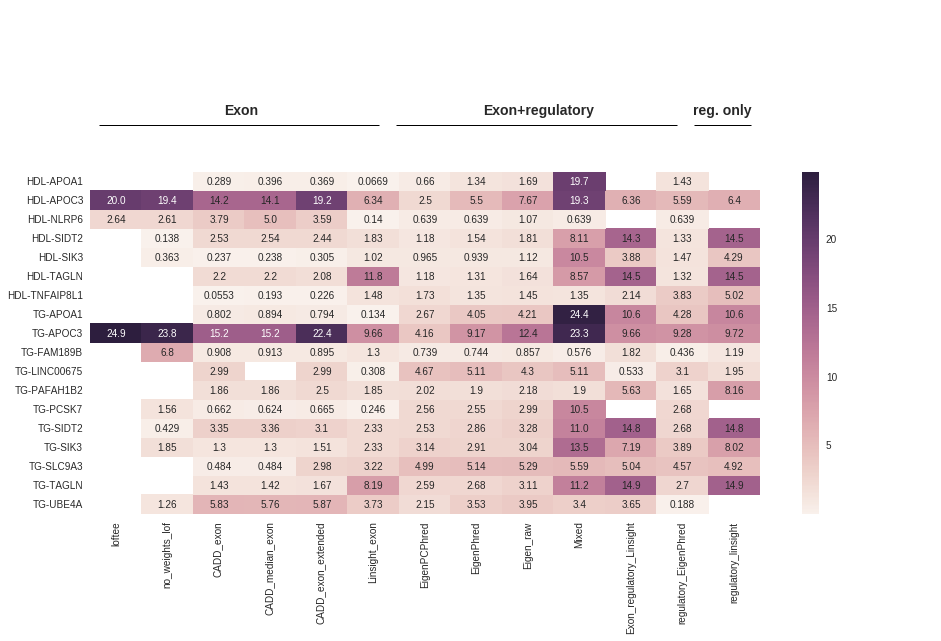

In [16]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import collections  as mc
sns.set_style("white")
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])
plt.figure(figsize=(15, 9))
ax0=plt.subplot(gs[0])
ax0.axis('off')
step=0.8/9
margin=0.01
lc = mc.LineCollection([[(0+margin,0), (step*4-margin,0)], 
                        [(step*4+margin,0),(step*8-margin,0)], 
                        [(step*8+margin,0), (step*9-margin,0)]], 
                       color="black", linewidths=3)
ax0.add_collection(lc)
ax0.text(x=0.16, y=0.1, s="Exon", fontweight="bold", fontsize=14)
ax0.text(x=0.47, y=0.1, s="Exon+regulatory", fontweight="bold", fontsize=14)
ax0.text(x=0.72, y=0.1, s="reg. only", fontweight="bold", fontsize=14)
ax1=plt.subplot(gs[1])

sns.heatmap(dmat, annot=True, fmt=".3", ax=ax1)